# Sprint 10 Project

# Library Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import random
import numpy as np
import math
from numpy.random import RandomState
pd.options.mode.chained_assignment = None
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, mean_absolute_error, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

# Extra Functions

In [2]:
def full_stats(data):
    mean = data.mean()
    median = data.quantile(0.50)
    minimum = data.min()
    maximum = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    big_outliers = q3 + (1.5*iqr)
    small_outliers = q1 - (1.5*iqr)
    stdev = np.std(data)
    variance = np.var(data)
    deviations = data - mean
    display(deviations)
    #sns.boxplot(data)
    report = pd.DataFrame(data={'minimum':[minimum],
                                'q1':[q1],
                                'median':[median],
                                'q3':[q3],
                                'maximum':[maximum],
                                'iqr':[iqr],
                                'big_outliers':[big_outliers],
                                'small_outliers':[small_outliers],
                                'standard_deviation':[stdev],
                                'variance':[variance]})
    return report

In [3]:
def get_stats(data):
    count = data.count()
    mean = data.mean()
    median = data.quantile(0.50)
    minimum = data.min()
    maximum = data.max()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    big_outliers = q3 + (1.5*iqr)
    small_outliers = q1 - (1.5*iqr)
    stdev = np.std(data)
    variance = np.var(data)
    deviations = abs(data - mean)
    mad = deviations.mean()
    return [count,minimum,q1,median,q3,maximum,iqr,big_outliers,small_outliers,stdev,variance,mad]

In [4]:
def display_stats(data,metal):
    data = []
    for col in metal:
        data.append(full.groupby('date')[col].sum())
    plt.boxplot(data,
                showfliers=False,
                vert=False,
                labels=metal)
    plt.show()

In [5]:
def profit(target, predicted, count):
    target = pd.Series(target.values)
    predicted = pd.Series(predicted.values)
    predicted_sorted = predicted.sort_values(ascending=False)
    selected = target[predicted_sorted.index][:count]
    selected_total = selected.sum()
    return ((selected_total * income_per_volume) - budget_total)

In [6]:
def revenue_bootstrapping(target, predicted):
    target = pd.Series(target.values)
    values = []
    predicted = pd.Series(predicted)
    state = np.random.RandomState(random_state)
    for i in range(1000):
        target_subsample = target.sample(n=n_points_all,replace=True,random_state=state)
        predicted_subsample = predicted[target_subsample.index]
        values.append(profit(target_subsample,predicted_subsample,n_best_points))
    values = pd.Series(values)
    return values

In [7]:
def cv_test(df,features,target):
    scores = []
    rmses=[]
    
    sample_size = int(len(df) / 5)

    for i in range(0, len(df), sample_size):
        valid_indexes = list(range(i, i + sample_size))
        train_indexes = list(range(0, i)) + list(range(i + sample_size, len(df)))

        features_train = features.iloc[train_indexes]
        features_valid = features.iloc[valid_indexes]

        target_train = target.iloc[train_indexes]
        target_valid = target.iloc[valid_indexes]

        model = LinearRegression().fit(features_train, target_train)
        score = model.score(features_valid, target_valid)
        predictions = model.predict(features_valid)
        rmses.append(mean_squared_error(target_valid,predictions)**0.5)
        scores.append(score)
    return round(sum(scores)/len(scores),3),round(sum(rmses)/len(rmses),3)

In [8]:
def scoring(model, features, target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse**0.5
    score = model.score(features, target)
    avg_volume = sum(predictions)/len(predictions)
    return rmse, score, avg_volume

In [9]:
def lr_train(features_train, target_train, features_valid, target_valid):
    lr = LinearRegression().fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    return lr,predictions

In [10]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [11]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [12]:
def get_scores(model, features, target, predictions):
    score = model.score(features, target)
    avg_volume = sum(predictions)/len(predictions)
    r2 = r2_score(target,predictions)
    mse = mean_squared_error(target,predictions)
    mae = mean_absolute_error(target,predictions)
    rmse = mse**0.5
    return score, avg_volume, r2, mse, mae, rmse

In [13]:
def one_report(model, features, target, predictions):
    score = model.score(features, target)
    avg_volume = sum(predictions)/len(predictions)
    r2 = r2_score(target,predictions)
    mse = mean_squared_error(target,predictions)
    mae = mean_absolute_error(target,predictions)
    rmse = mse**0.5
    report = pd.DataFrame({'r2_score':r2,
                           'mean_squared_error':mse,
                           'rmse':rmse,
                           'mean_absolute_error':mae,
                           'model_score':score,
                           'average_volume':avg_volume})
    return report

In [14]:
def all_reports(models, all_features, all_targets, all_predictions):
    report = pd.DataFrame(columns=['r2_score',
                                   'mean_squared_error',
                                   'rmse',
                                   'mean_absolute_error',
                                   'score',
                                   'average_volume',
                                   'prediction_mean'])
    for index in range(len(models)):
        score = models[index].score(all_features[index], all_targets[index])
        avg_volume = sum(all_predictions[index])/len(all_predictions[index])
        r2 = r2_score(all_targets[index],all_predictions[index])
        mse = mean_squared_error(all_targets[index],all_predictions[index])
        mae = mean_absolute_error(all_targets[index],all_predictions[index])
        rmse = mse**0.5
        pred_mean = all_predictions[index].mean()
        report.loc[index] = [round(r2,3), 
                             round(mse,3), 
                             round(rmse,3), 
                             round(mae,3), 
                             round(score,3), 
                             round(avg_volume,3),
                             round(pred_mean,3)]
    #report.style.set_properties(**{'text-align': 'center'})
    return report

## Prepare the Data

### Open the files and look into the data.

In [15]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [17]:
train.describe()

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 16788.000000                 16788.000000   
mean                      4.716907                     9.113559   
std                       2.096718                     3.389495   
min                       0.000000                     0.000000   
25%                       3.971262                     8.825748   
50%                       4.869346                    10.065316   
75%                       5.821176                    11.054809   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  16490.000000                 16789.000000   
mean                       8.301123                    39.467217   
std                        3.825760                    13.917227   
min                        0.000000                     0.000000   
25%                        6.939185                    42.055722   
50%                        8.557228                    44.498874   
75%                       10.289741                    45.976222   
max                       18.124851                    53.611374   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           15339.000000          16794.000000          16677.000000   
mean               67.213166              8.757048              2.360327   
std                11.960446              3.634103              1.215576   
min                 0.000000              0.000000              0.000000   
25%                62.625685              7.610544              1.641604   
50%                67.644601              9.220393              2.453690   
75%                72.824595             10.971110              3.192404   
max               100.000000             19.552149              6.086532   

       final.output.tail_sol  final.output.tail_au  \
count           16715.000000          16794.000000   
mean                9.303932              2.687512   
std                 4.263208              1.272757   
min                 0.000000              0.000000   
25%                 7.870275              2.172953   
50%                10.021968              2.781132   
75%                11.648573              3.416936   
max                22.317730              9.789625   

       primary_cleaner.input.sulfate  ...  \
count                   15553.000000  ...   
mean                      129.479789  ...   
std                        45.386931  ...   
min                         0.000003  ...   
25%                       103.064021  ...   
50%                       131.783108  ...   
75%                       159.539839  ...   
max                       251.999948  ...   

       secondary_cleaner.state.floatbank4_a_air  \
count                              16731.000000   
mean                                  19.101874   
std                                    6.883163   
min                                    0.000000   
25%                                   14.508299   
50%                                   19.986958   
75%                                   24.983961   
max                                   60.000000   

       secondary_cleaner.state.floatbank4_a_level  \
count                                16747.000000   
mean                                  -494.164481   
std                                     84.803334   
min                                   -799.920713   
25%                                   -500.837689   
50%                                   -499.778379   
75%                                   -494.648754   
max                                   -127.692333   

       secondary_cleaner.state.floatbank4_b_air  \
count                              16768.000000   
mean                                  14.778164   
std                                    5.999149   
min                                    0.000000   
25%                

In [18]:
train.dropna()

date  final.output.concentrate_ag  \
0      2016-01-15 00:00:00                     6.055403   
1      2016-01-15 01:00:00                     6.029369   
2      2016-01-15 02:00:00                     6.055926   
3      2016-01-15 03:00:00                     6.047977   
4      2016-01-15 04:00:00                     6.148599   
...                    ...                          ...   
16855  2018-08-18 06:59:59                     3.224920   
16856  2018-08-18 07:59:59                     3.195978   
16857  2018-08-18 08:59:59                     3.109998   
16858  2018-08-18 09:59:59                     3.367241   
16859  2018-08-18 10:59:59                     3.598375   

       final.output.concentrate_pb  final.output.concentrate_sol  \
0                         9.889648                      5.507324   
1                         9.968944                      5.257781   
2                        10.213995                      5.383759   
3                         9.977019                      4.858634   
4                        10.142511                      4.939416   
...                            ...                           ...   
16855                    11.356233                      6.803482   
16856                    11.349355                      6.862249   
16857                    11.434366                      6.886013   
16858                    11.625587                      6.799433   
16859                    11.737832                      6.717509   

       final.output.concentrate_au  final.output.recovery  \
0                        42.192020              70.541216   
1                        42.701629              69.266198   
2                        42.657501              68.116445   
3                        42.689819              68.347543   
4                        42.774141              66.927016   
...                            ...                    ...   
16855                    46.713954              73.755150   
16856                    46.866780              69.049291   
16857                    46.795691              67.002189   
16858                    46.408188              65.523246   
16859                    46.299438              70.281454   

       final.output.tail_ag  final.output.tail_pb  final.output.tail_sol  \
0                 10.411962              0.895447              16.904297   
1                 10.462676              0.927452              16.634514   
2                 10.507046              0.953716              16.208849   
3                 10.422762              0.883763              16.532835   
4                 10.360302              0.792826              16.525686   
...                     ...                   ...                    ...   
16855              8.769645              3.141541              10.403181   
16856              8.897321              3.130493              10.549470   
16857              8.529606              2.911418              11.115147   
16858              8.777171              2.819214              10.463847   
16859              8.406690              2.517518              10.652193   

       final.output.tail_au  ...  secondary_cleaner.state.floatbank4_a_air  \
0                  2.143149  ...                                 14.016835   
1                  2.224930  ...                                 13.992281   
2                  2.257889  ...                                 14.015015   
3                  2.146849  ...                                 14.036510   
4                  2.055292  ...                                 14.027298   
...                     ...  ...                                       ...   
16855              1.529220  ...                                 23.031497   
16856              1.612542  ...                                 22.960095   
16857              1.596616  ...                                 23.015718   
16858              1.602879  ...                                 23.02

Dropping any row with an empty cell removes over 1/3 of the training set. That seems to be way too much, so I will keep everything for now.

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [20]:
test.describe()

primary_cleaner.input.sulfate  primary_cleaner.input.depressant  \
count                    5554.000000                       5572.000000   
mean                      170.515243                          8.482873   
std                        49.608602                          3.353105   
min                         0.000103                          0.000031   
25%                       143.340022                          6.411500   
50%                       176.103893                          8.023252   
75%                       207.240761                         10.017725   
max                       274.409626                         40.024582   

       primary_cleaner.input.feed_size  primary_cleaner.input.xanthate  \
count                      5856.000000                     5690.000000   
mean                          7.264651                        1.321420   
std                           0.611526                        0.693246   
min                           5.650000                        0.000003   
25%                           6.885625                        0.888769   
50%                           7.259333                        1.183362   
75%                           7.650000                        1.763797   
max                          15.500000                        5.433169   

       primary_cleaner.state.floatbank8_a_air  \
count                             5840.000000   
mean                              1481.990241   
std                                310.453166   
min                                  0.000000   
25%                               1497.190681   
50%                               1554.659783   
75%                               1601.681656   
max                               2212.432090   

       primary_cleaner.state.floatbank8_a_level  \
count                               5840.000000   
mean                                -509.057796   
std                                   61.339256   
min                                 -799.773788   
25%                                 -500.455211   
50%                                 -499.997402   
75%                                 -499.575313   
max                                  -57.195404   

       primary_cleaner.state.floatbank8_b_air  \
count                             5840.000000   
mean                              1486.908670   
std                                313.224286   
min                                  0.000000   
25%                               1497.150234   
50%                               1553.268084   
75%                               1601.784707   
max                               1975.147923   

       primary_cleaner.state.floatbank8_b_level  \
count                               5840.000000   
mean                                -511.743956   
std                                   67.139074   
min                                 -800.029078   
25%                                 -500.936639   
50%                                 -500.066588   
75%                                 -499.323361   
max                                 -142.527229   

       primary_cleaner.state.floatbank8_c_air  \
count                             5840.000000   
mean                              1468.495216   
std                                309.980748   
min                                  0.000000   
25%                               1437.050321   
50%                               1546.160672   
75%                               1600.785573   
max                               1715.053773   

       primary_cleaner.state.floatbank8_c_level  ...  \
count                               5840.000000  ...   
mean                                -509.741212  ...   
std                                   62.671873  ...   
min                                 -799.995127  ...   
25%                                 -501.300441  ...   
50%                                 -500.079537  ...   
75%                                

In [21]:
test.head()

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   

   primary_cleaner.state.floatbank8_c_air  ...  \
0                             1400.102998  ...   
1                             1396.151033  ...   
2                             1398.075709  ...   
3                             1400.129303  ...   
4                             1402.172226  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 12.023554   
1                                 12.058140   
2                                 11.962366   
3                                 12.033091   
4                                 12.025367   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -497.795834   
1                                 -498.695773   
2                                 -498.767484   
3                                 -498.350935   
4                                 -500.786497   

   secondary_cleaner.state.floatbank4_b_air  \
0                                  8.016656   
1                                  8.130979   
2                                  8.096893   
3                                  8.074946   
4                                  8.054678   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -501.289139   
1                                 -499.634209   
2                                 -500.827423   
3                                 -499.474407   
4                                 -500.397500   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  7.946562   
1                                  7.958270   
2                                  8.071056   
3                                  7.897085   
4                                  8.107890   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -432.317850   
1                                 -525.839648   
2                                 -500.801673   
3     

In [22]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [23]:
full.describe()

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 22627.000000                 22629.000000   
mean                      4.781559                     9.095308   
std                       2.030128                     3.230797   
min                       0.000000                     0.000000   
25%                       4.018525                     8.750171   
50%                       4.953729                     9.914519   
75%                       5.862593                    10.929839   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  22331.000000                 22630.000000   
mean                       8.640317                    40.001172   
std                        3.785035                    13.398062   
min                        0.000000                     0.000000   
25%                        7.116799                    42.383721   
50%                        8.908792                    44.653436   
75%                       10.705824                    46.111999   
max                       19.615720                    53.611374   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           20753.000000          22633.000000          22516.000000   
mean               67.447488              8.923690              2.488252   
std                11.616034              3.517917              1.189407   
min                 0.000000              0.000000              0.000000   
25%                63.282393              7.684016              1.805376   
50%                68.322258              9.484369              2.653001   
75%                72.950836             11.084557              3.287790   
max               100.000000             19.552149              6.086532   

       final.output.tail_sol  final.output.tail_au  \
count           22445.000000          22635.000000   
mean                9.523632              2.827459   
std                 4.079739              1.262834   
min                 0.000000              0.000000   
25%                 8.143576              2.303108   
50%                10.212998              2.913794   
75%                11.860824              3.555077   
max                22.861749              9.789625   

       primary_cleaner.input.sulfate  ...  \
count                   21107.000000  ...   
mean                      140.277672  ...   
std                        49.919004  ...   
min                         0.000003  ...   
25%                       110.177081  ...   
50%                       141.330501  ...   
75%                       174.049914  ...   
max                       274.409626  ...   

       secondary_cleaner.state.floatbank4_a_air  \
count                              22571.000000   
mean                                  18.205125   
std                                    6.560700   
min                                    0.000000   
25%                                   14.095940   
50%                                   18.007326   
75%                                   22.998194   
max                                   60.000000   

       secondary_cleaner.state.floatbank4_a_level  \
count                                22587.000000   
mean                                  -499.878977   
std                                     80.273964   
min                                   -799.920713   
25%                                   -500.896232   
50%                                   -499.917108   
75%                                   -498.361545   
max                                   -127.692333   

       secondary_cleaner.state.floatbank4_b_air  \
count                              22608.000000   
mean                                  14.356474   
std                                    5.655791   
min                                    0.000000   
25%                

In [24]:
full.head()

date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   

   secondary_cleaner.state.floatbank4_b_air  \
0                                 12.099931   
1                                 11.950531   
2                                 11.912783   
3                                 11.999550   
4                                 11.953070   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -504.715942   
1                                 -501.331529   
2                                 -501.133383   
3                                 -501.193686   
4                                 -501.053894   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  9.925633   
1                                 10.039245   
2                                 10.070913   
3                                  9.970366   
4                                  9.925709   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -498.310211   
1                                 -500.169983   
2                                 -500.129135   
3                                 -499.201640   
4                                 -501.686727   

   secondary_cleaner.state.floatbank5_b_air  \
0                                  8.079666   
1                                  7.984757   
2                                  8.013877   
3                                  7.977324   
4                                  7.894242   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.470978   
1                                 -500.582168   
2                                 -500.517572   
3                                 -500.255908   
4                                 -500.356035   

   secondary_cleaner.state.floatbank6_a_air  \
0    

### Check that recovery is calculated correctly.

In [25]:
train[train['rougher.output.recovery'].notna()]['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 14287, dtype: float64

In [26]:
train[train['rougher.output.recovery'].notna()]['rougher.output.recovery'].sort_values(ascending=False).head(10)

13037    100.000000
13035    100.000000
12567    100.000000
13039    100.000000
13038    100.000000
13036    100.000000
15688     99.979041
13784     99.847663
7202      99.772958
16655     99.617781
Name: rougher.output.recovery, dtype: float64

In [27]:
C = train[train['rougher.output.tail_au'].notna() & train['rougher.input.feed_au'].notna() & train['rougher.output.concentrate_au'].notna()]['rougher.output.concentrate_au']

In [28]:
F = train[train['rougher.output.tail_au'].notna() & train['rougher.input.feed_au'].notna() & train['rougher.output.concentrate_au'].notna()]['rougher.input.feed_au']

In [29]:
T = train[train['rougher.output.tail_au'].notna() & train['rougher.input.feed_au'].notna() & train['rougher.output.concentrate_au'].notna()]['rougher.output.tail_au']

In [30]:
train['recovery'] = ((C*(F-T))/(F*(C-T)))*100
display(train[train['recovery'].notna()]['recovery'])

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: recovery, Length: 14577, dtype: float64

In [31]:
train['rougher.output.recovery'] = train['rougher.output.recovery'].fillna(0)
train['recovery'] = train['recovery'].fillna(0)

In [32]:
mae = mean_absolute_error(train['rougher.output.recovery'],train['recovery'].notna())

In [33]:
display(mae)

69.1632237642169

Based on mean absolute error alone, it appears that recovery was not calculated correctly. Let's do some further investigation on how far off the calculations were.

In [34]:
train['error'] = round(abs(train['rougher.output.recovery']-train['recovery']),3)

In [35]:
display(train[train['error']==0]['error'])

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
16855    0.0
16856    0.0
16857    0.0
16858    0.0
16859    0.0
Name: error, Length: 16570, dtype: float64

In [36]:
display(1-(len(train[train['error']!=0]['error'])/(len(train[train['error']==0]['error'])+len(train[train['error']!=0]['error']))))

0.9827995255041518

This number represents that over 98% of the time, the recovery was calculated correctly. I will now further analyze the distribution of error and see how making a mistake 1.7% of the time produces such a large mae.

In [37]:
display(train[train['error']!=0][['error',
                                  'rougher.output.recovery',
                                  'rougher.output.concentrate_au',
                                  'rougher.input.feed_au',
                                  'rougher.output.tail_au']].sort_values(by='error', ascending=False))

error  rougher.output.recovery  rougher.output.concentrate_au  \
3089     inf                      0.0                      24.224868   
3083     inf                      0.0                      24.409254   
3085     inf                      0.0                      22.968800   
3086     inf                      0.0                      23.576810   
3087     inf                      0.0                      24.006272   
...      ...                      ...                            ...   
15681  0.243                      0.0                       0.010000   
16286  0.235                      0.0                       0.010000   
15680  0.231                      0.0                       0.010000   
14000  0.209                      0.0                       0.010000   
14845  0.062                      0.0                       0.010000   

       rougher.input.feed_au  rougher.output.tail_au  
3089                0.000000                2.916833  
3083                0.000000                1.637472  
3085                0.000000                2.164390  
3086                0.000000                3.211033  
3087                0.000000                2.798918  
...                      ...                     ...  
15681               6.963635                2.590886  
16286               9.210337                2.915845  
15680               8.855757                2.911861  
14000               7.522018                2.929708  
14845               2.206914                1.942978  

[290 rows x 5 columns]

There are 30 cases where the error was infinity. It should actually be nan because the input.feed_au was 0. Then, calculating recovery, there was dividing by 0 which cannot be done. These actually should not affect the mae, so now I will look at all errors that are not infinte.

In [38]:
display(train[train['error']>0 | (train['error'].isin([np.inf]))][[
                                  'error',
                                  'rougher.output.recovery',
                                  'recovery',
                                  'rougher.output.concentrate_au',
                                  'rougher.input.feed_au',
                                  'rougher.output.tail_au']].sort_values(by='error', ascending=True)[:25])

error  rougher.output.recovery  recovery  \
14845  0.062                      0.0 -0.061871   
14000  0.209                      0.0 -0.209102   
15680  0.231                      0.0 -0.231296   
16286  0.235                      0.0 -0.235187   
15681  0.243                      0.0 -0.243304   
15678  0.249                      0.0 -0.248946   
15679  0.251                      0.0 -0.250611   
15677  0.253                      0.0 -0.252629   
16285  0.270                      0.0 -0.270125   
15676  0.276                      0.0 -0.275999   
15674  0.282                      0.0 -0.282288   
15675  0.288                      0.0 -0.288251   
15682  0.292                      0.0 -0.292389   
16284  0.313                      0.0 -0.312814   
15627  0.331                      0.0 -0.330806   
13883  0.339                      0.0 -0.339258   
13223  0.441                      0.0 -0.441366   
13222  0.454                      0.0 -0.453725   
12652  0.456                      0.0 -0.455711   
15683  0.465                      0.0 -0.464747   
15631  0.472                      0.0 -0.472487   
16403  0.479                      0.0 -0.478712   
16326  0.482                      0.0 -0.482239   
16699  0.483                      0.0 -0.482567   
16327  0.495                      0.0 -0.495070   

       rougher.output.concentrate_au  rougher.input.feed_au  \
14845                           0.01               2.206914   
14000                           0.01               7.522018   
15680                           0.01               8.855757   
16286                           0.01               9.210337   
15681                           0.01               6.963635   
15678                           0.01               9.209884   
15679                           0.01               9.259690   
15677                           0.01               9.180225   
16285                           0.01               9.078831   
15676                           0.01               8.845704   
15674                           0.01               8.461342   
15675                           0.01               8.456279   
15682                           0.01               5.205454   
16284                           0.01               8.776276   
15627                           0.01               9.979357   
13883                           0.01               5.455763   
13223                           0.01              11.552184   
13222                           0.01              11.889275   
12652                           0.01               8.072471   
15683                           0.01               9.779017   
15631                           0.01               9.289610   
16403                           0.01               8.603210   
16326                           0.01               8.552027   
16699                           0.01              10.149224   
16327                           0.01               9.086024   

       rougher.output.tail_au  
14845                1.942978  
14000                2.929708  
15680                2.911861  
16286                2.915845  
15681                2.590886  
15678                2.803967  
15679                2.795563  
15677                2.772791  
16285                2.636803  
15676                2.577472  
15674                2.504100  
15675                2.467075  
15682                2.070038  
16284                2.350579  
15627                2.327789  
13883                1.920182  
13223                1.902551  
13222                1.867746  
12652                1.733223  
15683                1.771845  
15631                1.731883  
16403                1.688865  
16326                1.677022  
16699                1.729189  
16327                1.660722

In [39]:
display(train['rougher.output.recovery'].min())
display(train['rougher.output.recovery'].max())

0.0

100.0

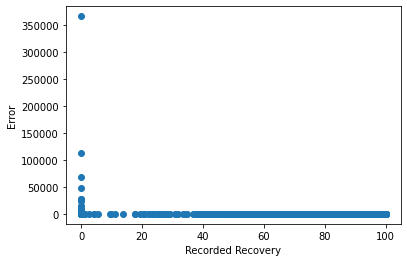

In [40]:
plt.scatter(data=train[['error','rougher.output.recovery']],
            y='error',
            x='rougher.output.recovery')
plt.xlabel('Recorded Recovery')
plt.ylabel('Error')
plt.show()

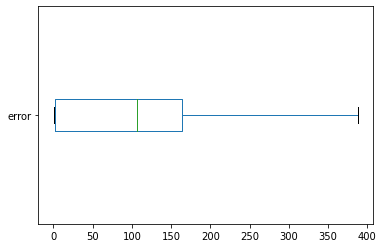

In [41]:
train[train['error']>0]['error'].plot(kind='box', 
                                       vert=False,
                                       showfliers=False)
plt.show()

<AxesSubplot:>

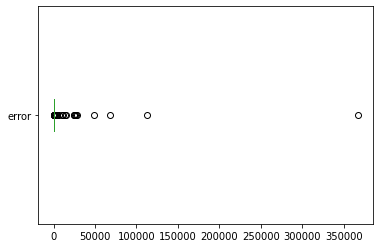

In [42]:
train[train['error']>0]['error'].plot(kind='box', 
                                       vert=False,
                                      showfliers=True)

<AxesSubplot:xlabel='error', ylabel='Density'>

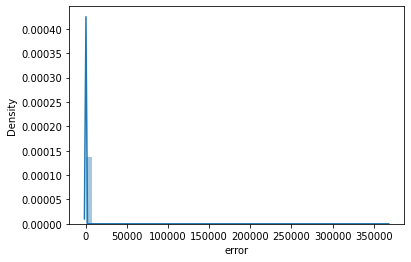

In [43]:
sns.distplot(train[~train['error'].isin([np.inf])]['error'])

In [44]:
outliers = train[train['error']>0]['error'].quantile(0.75) + 1.5*(train[train['error']>0]['error'].quantile(0.75) - train[train['error']>0]['error'].quantile(0.25))
display(outliers)

407.68462500000004

In [45]:
mae_no_outliers = mean_absolute_error(train[train['error']<outliers]['rougher.output.recovery'],train[train['error']<outliers]['recovery'])

In [46]:
mae_no_outliers

1.0875173751488512

In [47]:
display(len((train[train['error']>outliers][[
                                  'error',
                                  'rougher.output.recovery',
                                  'recovery',
                                  'rougher.output.concentrate_au',
                                  'rougher.input.feed_au',
                                  'rougher.output.tail_au']].sort_values(by='error', ascending=False))))

55

This shows that these 55 errors out of over 16,000 calculations made turns the mae from 1.0875 to 69.163. Therefore, the outliers should not be considered when asking of recovery is calculated correctly. Recovery was calculated correctly with a small sample of anomalies. The charts can support this too. Especially the box plots. When showing the distribution when an error occurred, 75% of the data is under 175, and about 99% is less than 400. This is all happening because I disregarded temporarily all of the calculations that had no error. If you put that back in, then over 98% of data values is 0 which means any error would be considered an outlier. Therefore, these 55 outliers are really outliers of the outliers. Outliers in data naturally mess up the mean, that is why the box plot which focuses on the median is a better choice for interpreting the distribution.

### Analyze features not available in the test set.

#### Identify features

In [48]:
display(test.columns)

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

All of the parameters not available in the test set are outputs and calculations. Also, the final stage has not been made available in the test set. This means we have access to the input of raw materials, the state of the stages, and all other stages besides the final stage. Everything will be analyzed using the full data set since we don't want to supply these answers to future models.

In [49]:
features = test.columns
targets = full.drop(features, axis=1).columns

In [50]:
display(targets)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

In [51]:
full[targets]

final.output.concentrate_ag  final.output.concentrate_pb  \
0                         6.055403                     9.889648   
1                         6.029369                     9.968944   
2                         6.055926                    10.213995   
3                         6.047977                     9.977019   
4                         6.148599                    10.142511   
...                            ...                          ...   
22711                     3.224920                    11.356233   
22712                     3.195978                    11.349355   
22713                     3.109998                    11.434366   
22714                     3.367241                    11.625587   
22715                     3.598375                    11.737832   

       final.output.concentrate_sol  final.output.concentrate_au  \
0                          5.507324                    42.192020   
1                          5.257781                    42.701629   
2                          5.383759                    42.657501   
3                          4.858634                    42.689819   
4                          4.939416                    42.774141   
...                             ...                          ...   
22711                      6.803482                    46.713954   
22712                      6.862249                    46.866780   
22713                      6.886013                    46.795691   
22714                      6.799433                    46.408188   
22715                      6.717509                    46.299438   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
0                  70.541216             10.411962              0.895447   
1                  69.266198             10.462676              0.927452   
2                  68.116445             10.507046              0.953716   
3                  68.347543             10.422762              0.883763   
4                  66.927016             10.360302              0.792826   
...                      ...                   ...                   ...   
22711              73.755150              8.769645              3.141541   
22712              69.049291              8.897321              3.130493   
22713              67.002189              8.529606              2.911418   
22714              65.523246              8.777171              2.819214   
22715              70.281454              8.406690              2.517518   

       final.output.tail_sol  final.output.tail_au  \
0                  16.904297              2.143149   
1                  16.634514              2.224930   
2                  16.208849              2.257889   
3                  16.532835              2.146849   
4                  16.525686              2.055292   
...                      ...                   ...   
22711              10.403181              1.529220   
22712              10.549470              1.612542   
22713              11.115147              1.596616   
22714              10.463847              1.602879   
22715              10.652193              1.389434   

       primary_cleaner.output.concentrate_ag  ...  \
0                                   8.547551  ...   
1                                   8.558743  ...   
2                                   8.603505  ...   
3                                   7.221879  ...   
4                                   9.089428  ...   
...                                      ...  ...   
22711                               6.559174  ...   
22712                               6.612376  ...   
22713                               7.128896  ...   
22714                               7.490444  ...   
22715                               7.537584  ...   

       rougher.output.concentrate_au  rougher.output.recovery  \
0                          19.793808                87.107763   
1                          20.050975                86.8

In [52]:
full[targets].describe()

final.output.concentrate_ag  final.output.concentrate_pb  \
count                 22627.000000                 22629.000000   
mean                      4.781559                     9.095308   
std                       2.030128                     3.230797   
min                       0.000000                     0.000000   
25%                       4.018525                     8.750171   
50%                       4.953729                     9.914519   
75%                       5.862593                    10.929839   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  22331.000000                 22630.000000   
mean                       8.640317                    40.001172   
std                        3.785035                    13.398062   
min                        0.000000                     0.000000   
25%                        7.116799                    42.383721   
50%                        8.908792                    44.653436   
75%                       10.705824                    46.111999   
max                       19.615720                    53.611374   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count           20753.000000          22633.000000          22516.000000   
mean               67.447488              8.923690              2.488252   
std                11.616034              3.517917              1.189407   
min                 0.000000              0.000000              0.000000   
25%                63.282393              7.684016              1.805376   
50%                68.322258              9.484369              2.653001   
75%                72.950836             11.084557              3.287790   
max               100.000000             19.552149              6.086532   

       final.output.tail_sol  final.output.tail_au  \
count           22445.000000          22635.000000   
mean                9.523632              2.827459   
std                 4.079739              1.262834   
min                 0.000000              0.000000   
25%                 8.143576              2.303108   
50%                10.212998              2.913794   
75%                11.860824              3.555077   
max                22.861749              9.789625   

       primary_cleaner.output.concentrate_ag  ...  \
count                           22618.000000  ...   
mean                                7.691652  ...   
std                                 3.109306  ...   
min                                 0.000000  ...   
25%                                 6.771102  ...   
50%                                 8.265643  ...   
75%                                 9.697896  ...   
max                                16.081632  ...   

       rougher.output.concentrate_au  rougher.output.recovery  \
count                   22618.000000             19597.000000   
mean                       17.879538                83.078122   
std                         6.790112                14.661880   
min                         0.000000                 0.000000   
25%                        17.928729                80.941306   
50%                        20.003202                86.144121   
75%                        21.564238                89.987561   
max                        28.824507               100.000000   

       rougher.output.tail_ag  rougher.output.tail_pb  \
count            19979.000000            22618.000000   
mean                 5.587861                0.593620   
std                  1.114614                0.315295   
min                  0.594562                0.000000   
25%                  4.887758                0.427513   
50%                  5.759630                0.590746   
75%                  6.386301                0.763219   
max                 12.719177                3.778064   

       rougher.output.tail_sol  rougher.

#### Split Data by Metal

In [53]:
silver = [col for col in full if 'ag' in col]

In [54]:
silver

['final.output.concentrate_ag',
 'final.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.tail_ag',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_ag',
 'rougher.output.tail_ag',
 'secondary_cleaner.output.tail_ag']

In [55]:
gold = [col for col in full if 'au' in col]

In [56]:
gold

['final.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au']

In [57]:
lead = [col for col in full if 'pb' in col]

In [58]:
lead

['final.output.concentrate_pb',
 'final.output.tail_pb',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_pb',
 'rougher.output.concentrate_pb',
 'rougher.output.tail_pb',
 'secondary_cleaner.output.tail_pb']

In [59]:
colloid = [col for col in full if 'sol' in col]

In [60]:
colloid

['final.output.concentrate_sol',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_sol',
 'rougher.input.feed_sol',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_sol',
 'secondary_cleaner.output.tail_sol']

#### Silver

In [61]:
silver_stats = pd.DataFrame(columns=['count','minimum','q1','median','q3','maximum','iqr','big_outliers',
                                    'small_outliers','standard_deviation','variance','mad'],
                           index=silver)

In [62]:
index = 0
for col in silver:
    silver_stats.loc[col] = get_stats(data=full[col])
    index += 1

In [63]:
display(silver_stats)

count   minimum         q1     median  \
final.output.concentrate_ag            22627       0.0   4.018525   4.953729   
final.output.tail_ag                   22633       0.0   7.684016   9.484369   
primary_cleaner.output.concentrate_ag  22618       0.0   6.771102   8.265643   
primary_cleaner.output.tail_ag         22614       0.0  13.464756  15.600454   
rougher.input.feed_ag                  22618       0.0   6.944415   8.302613   
rougher.output.concentrate_ag          22618       0.0  10.126646  11.785127   
rougher.output.tail_ag                 19979  0.594562   4.887758    5.75963   
secondary_cleaner.output.tail_ag       22616       0.0  11.802936  15.222165   

                                              q3    maximum       iqr  \
final.output.concentrate_ag             5.862593  16.001945  1.844068   
final.output.tail_ag                   11.084557  19.552149  3.400541   
primary_cleaner.output.concentrate_ag   9.697896  16.081632  2.926793   
primary_cleaner.output.tail_ag         17.931084  29.459575  4.466328   
rougher.input.feed_ag                  10.135202  14.869652  3.190787   
rougher.output.concentrate_ag          13.615299  24.480271  3.488654   
rougher.output.tail_ag                  6.386301  12.719177  1.498543   
secondary_cleaner.output.tail_ag       17.231611  23.264738  5.428675   

                                      big_outliers small_outliers  \
final.output.concentrate_ag               8.628694       1.252424   
final.output.tail_ag                     16.185368       2.583205   
primary_cleaner.output.concentrate_ag    14.088086       2.380913   
primary_cleaner.output.tail_ag           24.630577       6.765263   
rougher.input.feed_ag                    14.921383       2.158234   
rougher.output.concentrate_ag             18.84828       4.893665   
rougher.output.tail_ag                    8.634116       2.639943   
secondary_cleaner.output.tail_ag         25.374623       3.659924   

                                      standard_deviation   variance       mad  
final.output.concentrate_ag                     2.030083   4.121236   1.42078  
final.output.tail_ag                             3.51784  12.375196  2.541816  
primary_cleaner.output.concentrate_ag           3.109237   9.667355   2.24329  
primary_cleaner.output.tail_ag                  5.654217  31.970167  3.814565  
rougher.input.feed_ag                           3.125181   9.766754  2.264066  
rougher.output.concentrate_ag                   4.377827  19.165373  3.039991  
rougher.output.tail_ag                          1.114586   1.242303  0.895904  
secondary_cleaner.output.tail_ag                5.768591  33.276648   4.30573

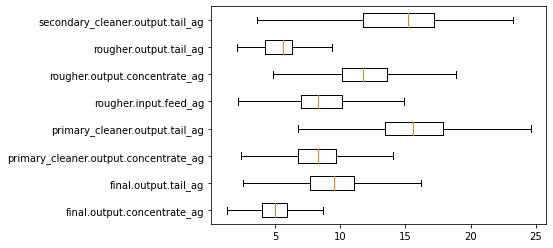

In [64]:
display_stats(full,silver)

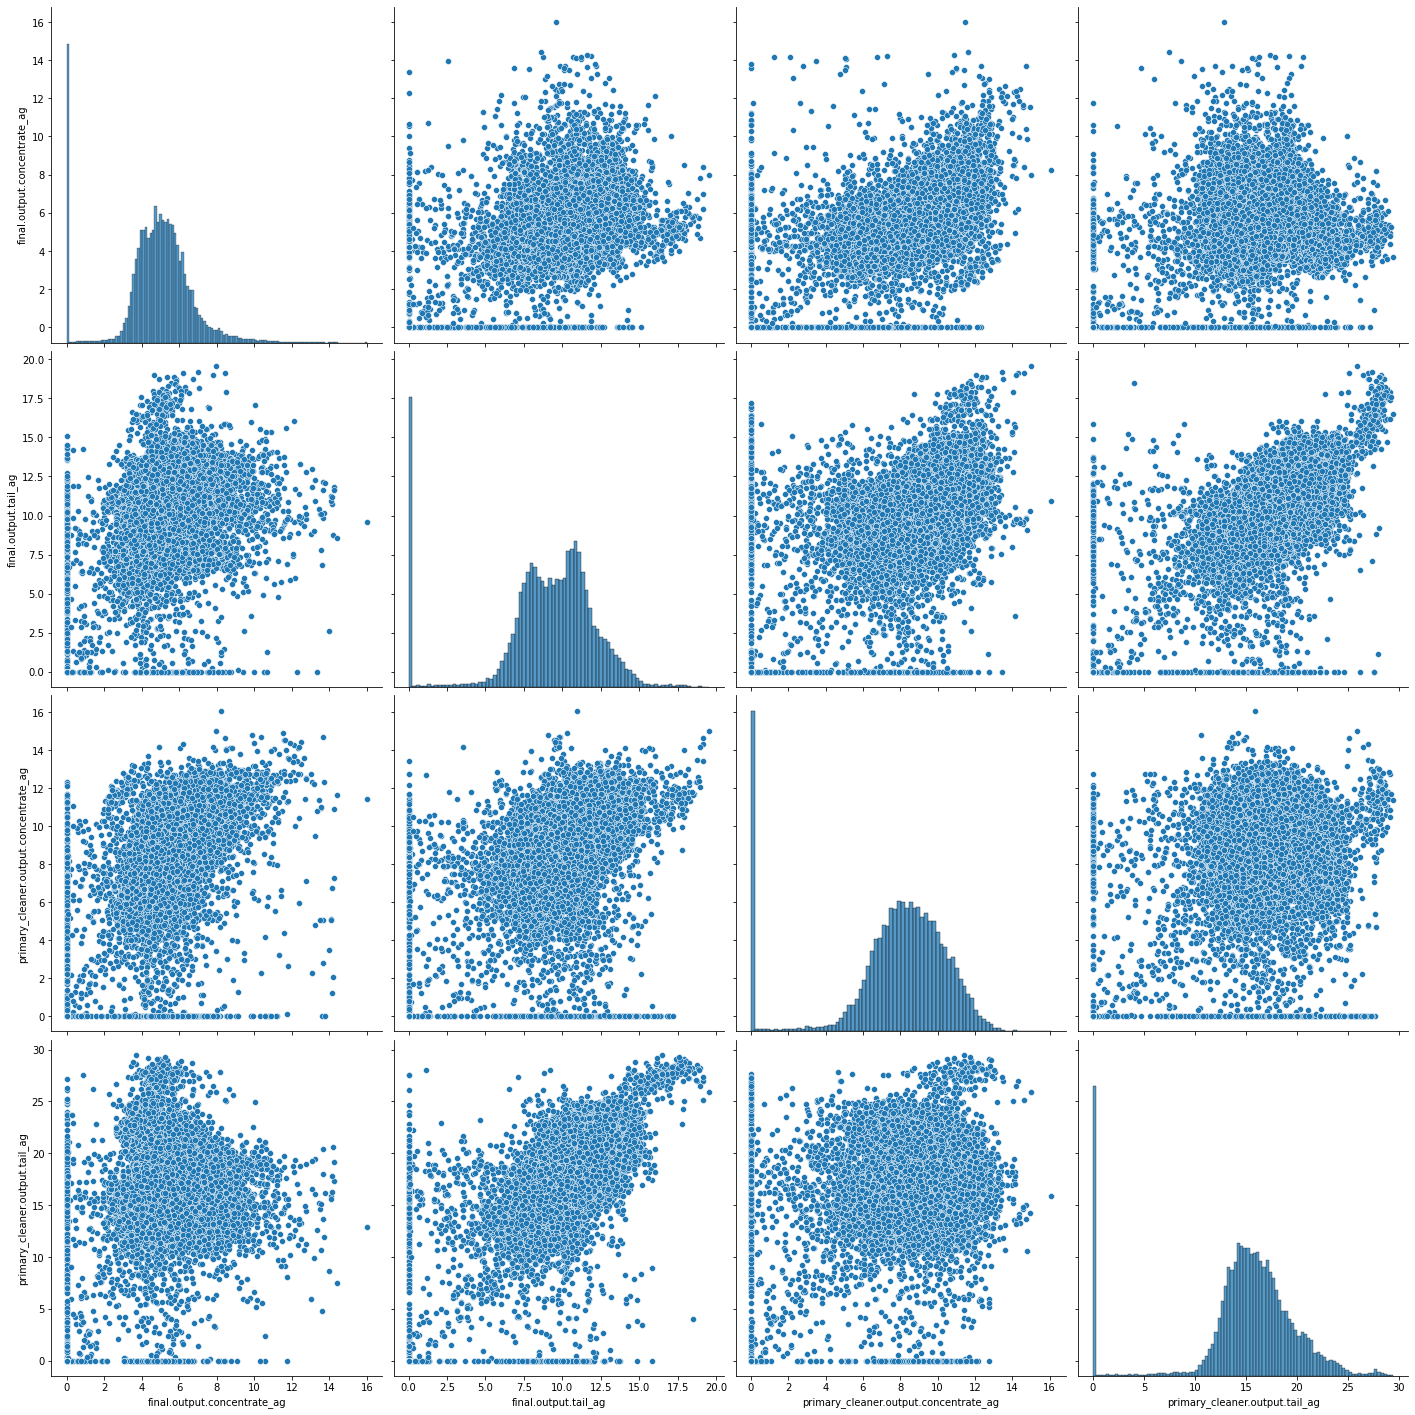

In [65]:
sns.pairplot(full[silver[:int(len(silver)/2)]],kind='scatter',height=5)

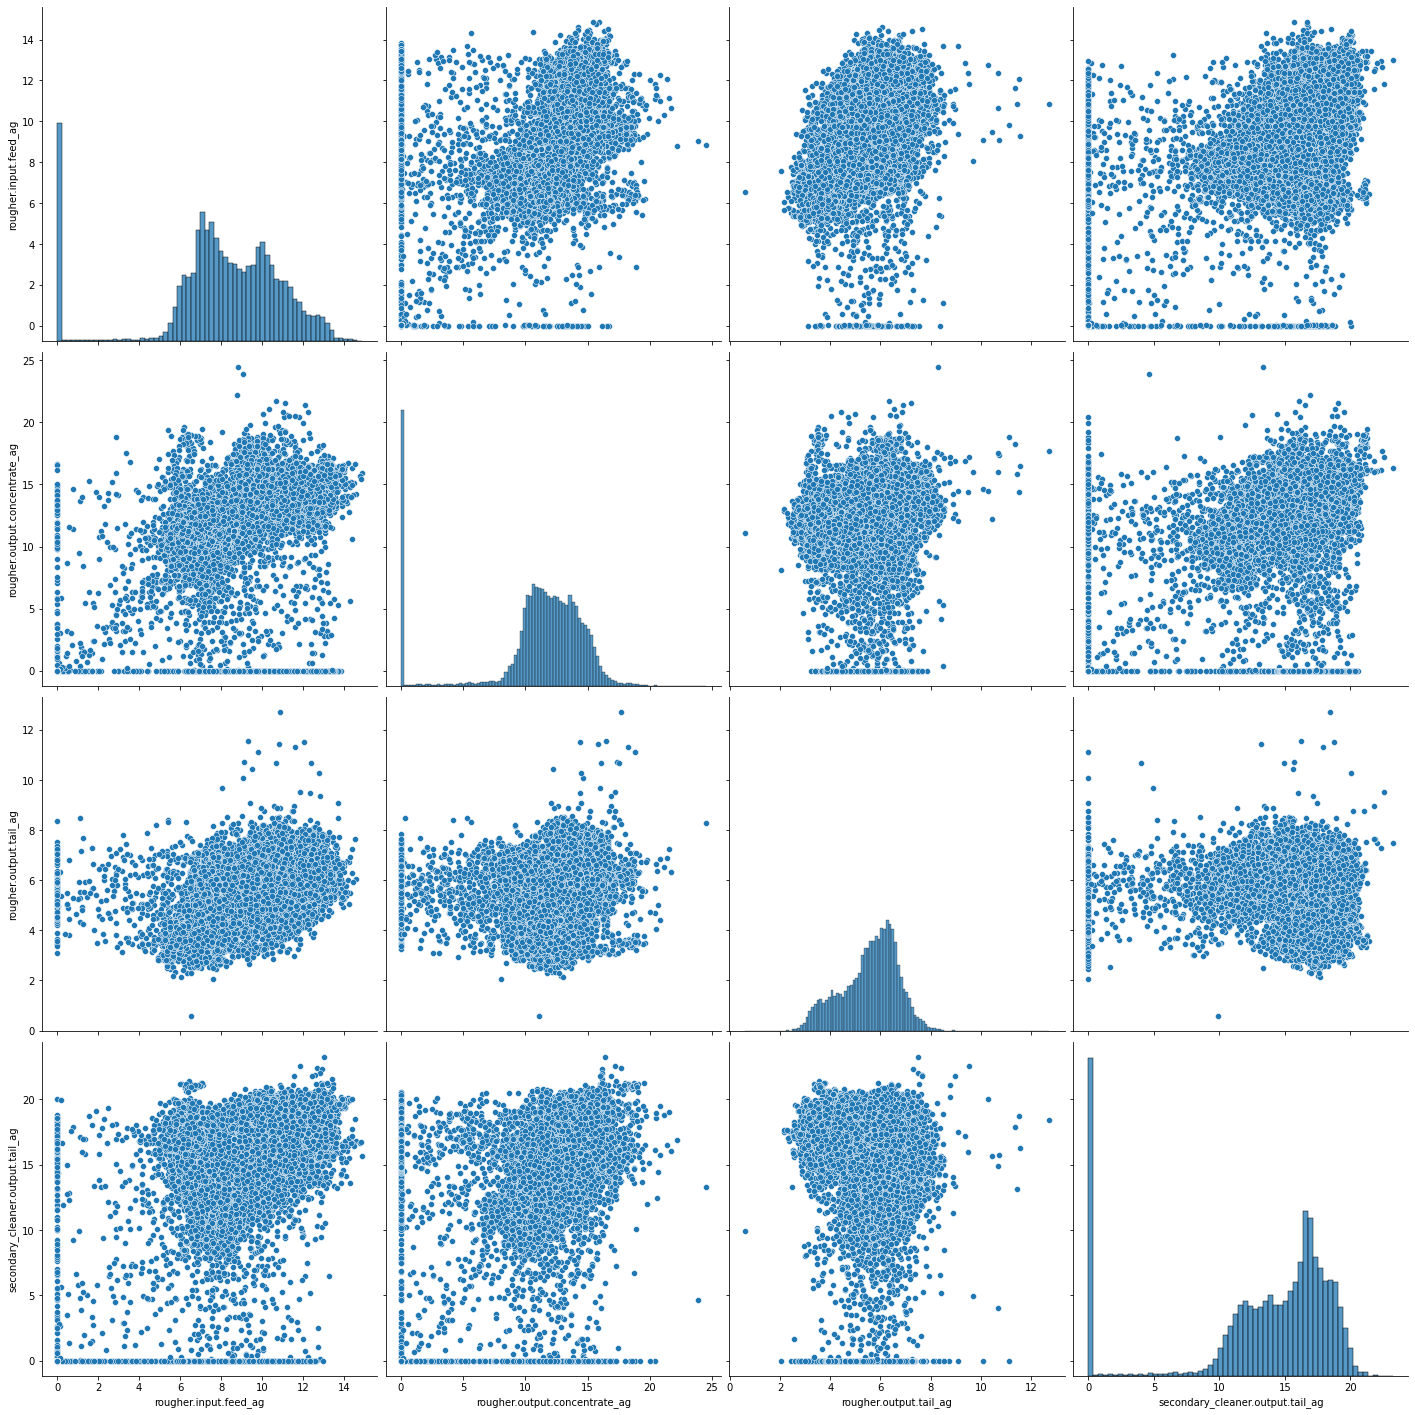

In [66]:
sns.pairplot(full[silver[int(len(silver)/2):]],kind='scatter',height=5)

#### Gold

In [67]:
gold_stats = pd.DataFrame(columns=['count','minimum','q1','median','q3','maximum','iqr','big_outliers',
                                    'small_outliers','standard_deviation','variance','mad'],
                           index=gold)

In [68]:
index = 0
for col in gold:
    gold_stats.loc[col] = get_stats(data=full[col])
    index += 1

In [69]:
display(gold_stats)

count            minimum  \
final.output.concentrate_au                         22630                0.0   
final.output.tail_au                                22635                0.0   
primary_cleaner.output.concentrate_au               22618                0.0   
primary_cleaner.output.tail_au                      22617                0.0   
rougher.calculation.sulfate_to_au_concentrate       22672 -2248016723.127841   
rougher.calculation.floatbank10_sulfate_to_au_feed  22672    -2023458.737974   
rougher.calculation.floatbank11_sulfate_to_au_feed  22672    -4014501.942585   
rougher.calculation.au_pb_ratio                     21089          -0.010548   
rougher.input.feed_au                               22617                0.0   
rougher.output.concentrate_au                       22618                0.0   
rougher.output.tail_au                              19980           0.020676   
secondary_cleaner.output.tail_au                    22618                0.0   

                                                             q1        median  \
final.output.concentrate_au                           42.383721     44.653436   
final.output.tail_au                                   2.303108      2.913794   
primary_cleaner.output.concentrate_au                 29.374406     32.359813   
primary_cleaner.output.tail_au                         2.741534      3.513008   
rougher.calculation.sulfate_to_au_concentrate        39884.7795  44059.287659   
rougher.calculation.floatbank10_sulfate_to_au_feed  2506.365727   2940.838046   
rougher.calculation.floatbank11_sulfate_to_au_feed  2501.745178   2897.014497   
rougher.calculation.au_pb_ratio                         2.02136      2.286493   
rougher.input.feed_au                                  6.485009      7.884832   
rougher.output.concentrate_au                         17.928729     20.003202   
rougher.output.tail_au                                 1.403951      1.808567   
secondary_cleaner.output.tail_au                       2.877554      3.956171   

                                                              q3  \
final.output.concentrate_au                            46.111999   
final.output.tail_au                                    3.555077   
primary_cleaner.output.concentrate_au                  34.770726   
primary_cleaner.output.tail_au                          4.559485   
rougher.calculation.sulfate_to_au_concentrate       48144.794934   
rougher.calculation.floatbank10_sulfate_to_au_feed   3613.982529   
rougher.calculation.floatbank11_sulfate_to_au_feed    3529.91274   
rougher.calculation.au_pb_ratio                          2.71107   
rougher.input.feed_au                                   9.668064   
rougher.output.concentrate_au                          21.564238   
rougher.output.tail_au                                  2.215317   
secondary_cleaner.output.tail_au                        5.006944   

                                                            maximum  \
final.output.concentrate_au                               53.611374   
final.output.tail_au                                       9.789625   
primary_cleaner.output.concentrate_au                     45.933934   
primary_cleaner.output.tail_au                            18.528821   
rougher.calculation.sulfate_to_au_concentrate       83324035.849295   
rougher.calculation.floatbank10_sulfate_to_au_feed   6211432.533073   
rougher.calculation.floatbank11_sulfate_to_au_feed   1537563.641296   
rougher.calculation.au_pb_ratio                           39.379272   
rougher.input.feed_au                                     14.093363   
rougher.output.concentrate_au                             28.824507   
rougher.output.tail_au                                      9.68898   
secondary_cleaner.output.tail_au                          26.811643   

                                                            iqr  big_outliers  \
final.output.concentrate_au                            3.728278    

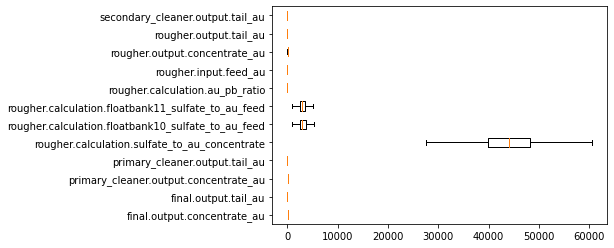

In [70]:
display_stats(full,gold)

In [ ]:
sns.pairplot(full[gold[:int(len(gold)/2)]],kind='scatter',height=5)

In [ ]:
sns.pairplot(full[gold[int(len(gold)/2):]],kind='scatter',height=5)

#### Lead

In [71]:
lead_stats = pd.DataFrame(columns=['count','minimum','q1','median','q3','maximum','iqr','big_outliers',
                                    'small_outliers','standard_deviation','variance','mad'],
                           index=lead)

In [72]:
index = 0
for col in lead:
    lead_stats.loc[col] = get_stats(data=full[col])
    index += 1

In [73]:
display(lead_stats)

count   minimum        q1    median  \
final.output.concentrate_pb            22629       0.0  8.750171  9.914519   
final.output.tail_pb                   22516       0.0  1.805376  2.653001   
primary_cleaner.output.concentrate_pb  22268       0.0   7.83469  9.921116   
primary_cleaner.output.tail_pb         22594       0.0  2.269103  3.154022   
rougher.calculation.au_pb_ratio        21089 -0.010548   2.02136  2.286493   
rougher.input.feed_pb                  22472       0.0  2.658814  3.432054   
rougher.output.concentrate_pb          22618       0.0  6.374692  7.572855   
rougher.output.tail_pb                 22618       0.0  0.427513  0.590746   
secondary_cleaner.output.tail_pb       22600       0.0  3.451435  5.074145   

                                              q3    maximum       iqr  \
final.output.concentrate_pb            10.929839  17.031899  2.179668   
final.output.tail_pb                     3.28779   6.086532  1.482415   
primary_cleaner.output.concentrate_pb    11.2661  17.081278   3.43141   
primary_cleaner.output.tail_pb          4.123574   9.634565  1.854471   
rougher.calculation.au_pb_ratio          2.71107  39.379272   0.68971   
rougher.input.feed_pb                    4.20496   7.142594  1.546146   
rougher.output.concentrate_pb           8.477358  18.394042  2.102666   
rougher.output.tail_pb                  0.763219   3.778064  0.335707   
secondary_cleaner.output.tail_pb        7.585281  17.042505  4.133845   

                                      big_outliers small_outliers  \
final.output.concentrate_pb              14.199342       5.480669   
final.output.tail_pb                      5.511412      -0.418246   
primary_cleaner.output.concentrate_pb    16.413216       2.687575   
primary_cleaner.output.tail_pb            6.905281      -0.512603   
rougher.calculation.au_pb_ratio           3.745634       0.986795   
rougher.input.feed_pb                     6.524179       0.339595   
rougher.output.concentrate_pb            11.631357       3.220692   
rougher.output.tail_pb                    1.266779      -0.076047   
secondary_cleaner.output.tail_pb         13.786049      -2.749333   

                                      standard_deviation   variance       mad  
final.output.concentrate_pb                     3.230726  10.437588  2.134184  
final.output.tail_pb                            1.189381   1.414626  0.940836  
primary_cleaner.output.concentrate_pb           3.706231   13.73615  2.762143  
primary_cleaner.output.tail_pb                   1.65214   2.729568  1.260994  
rougher.calculation.au_pb_ratio                 0.839979   0.705565  0.483196  
rougher.input.feed_pb                           1.446873   2.093442   1.08655  
rougher.output.concentrate_pb                   2.806886    7.87861  1.954792  
rougher.output.tail_pb                          0.315288   0.099407  0.229664  
secondary_cleaner.output.tail_pb                3.092467   9.563353  2.489384

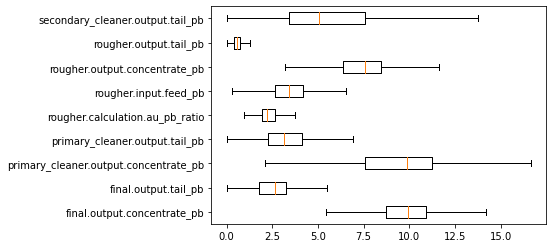

In [74]:
display_stats(full,lead)

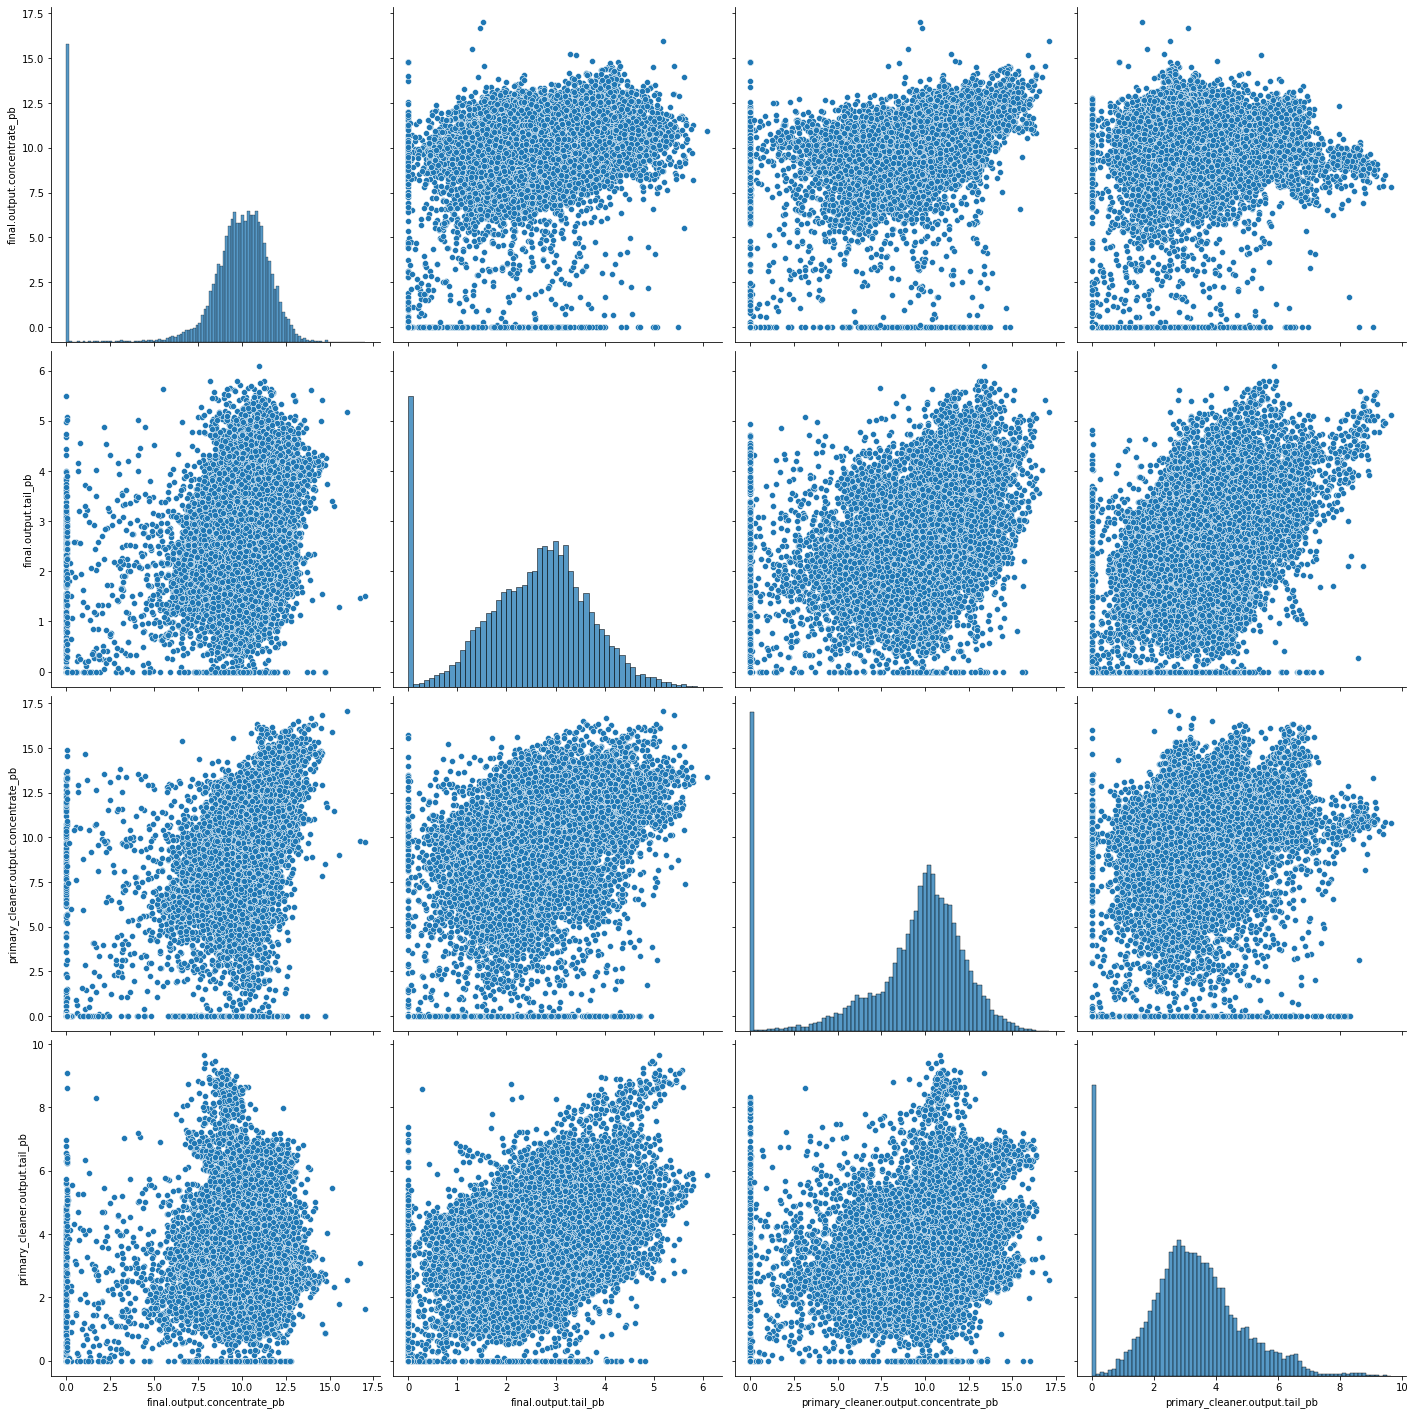

In [75]:
sns.pairplot(full[lead[:int(len(lead)/2)]],kind='scatter',height=5)

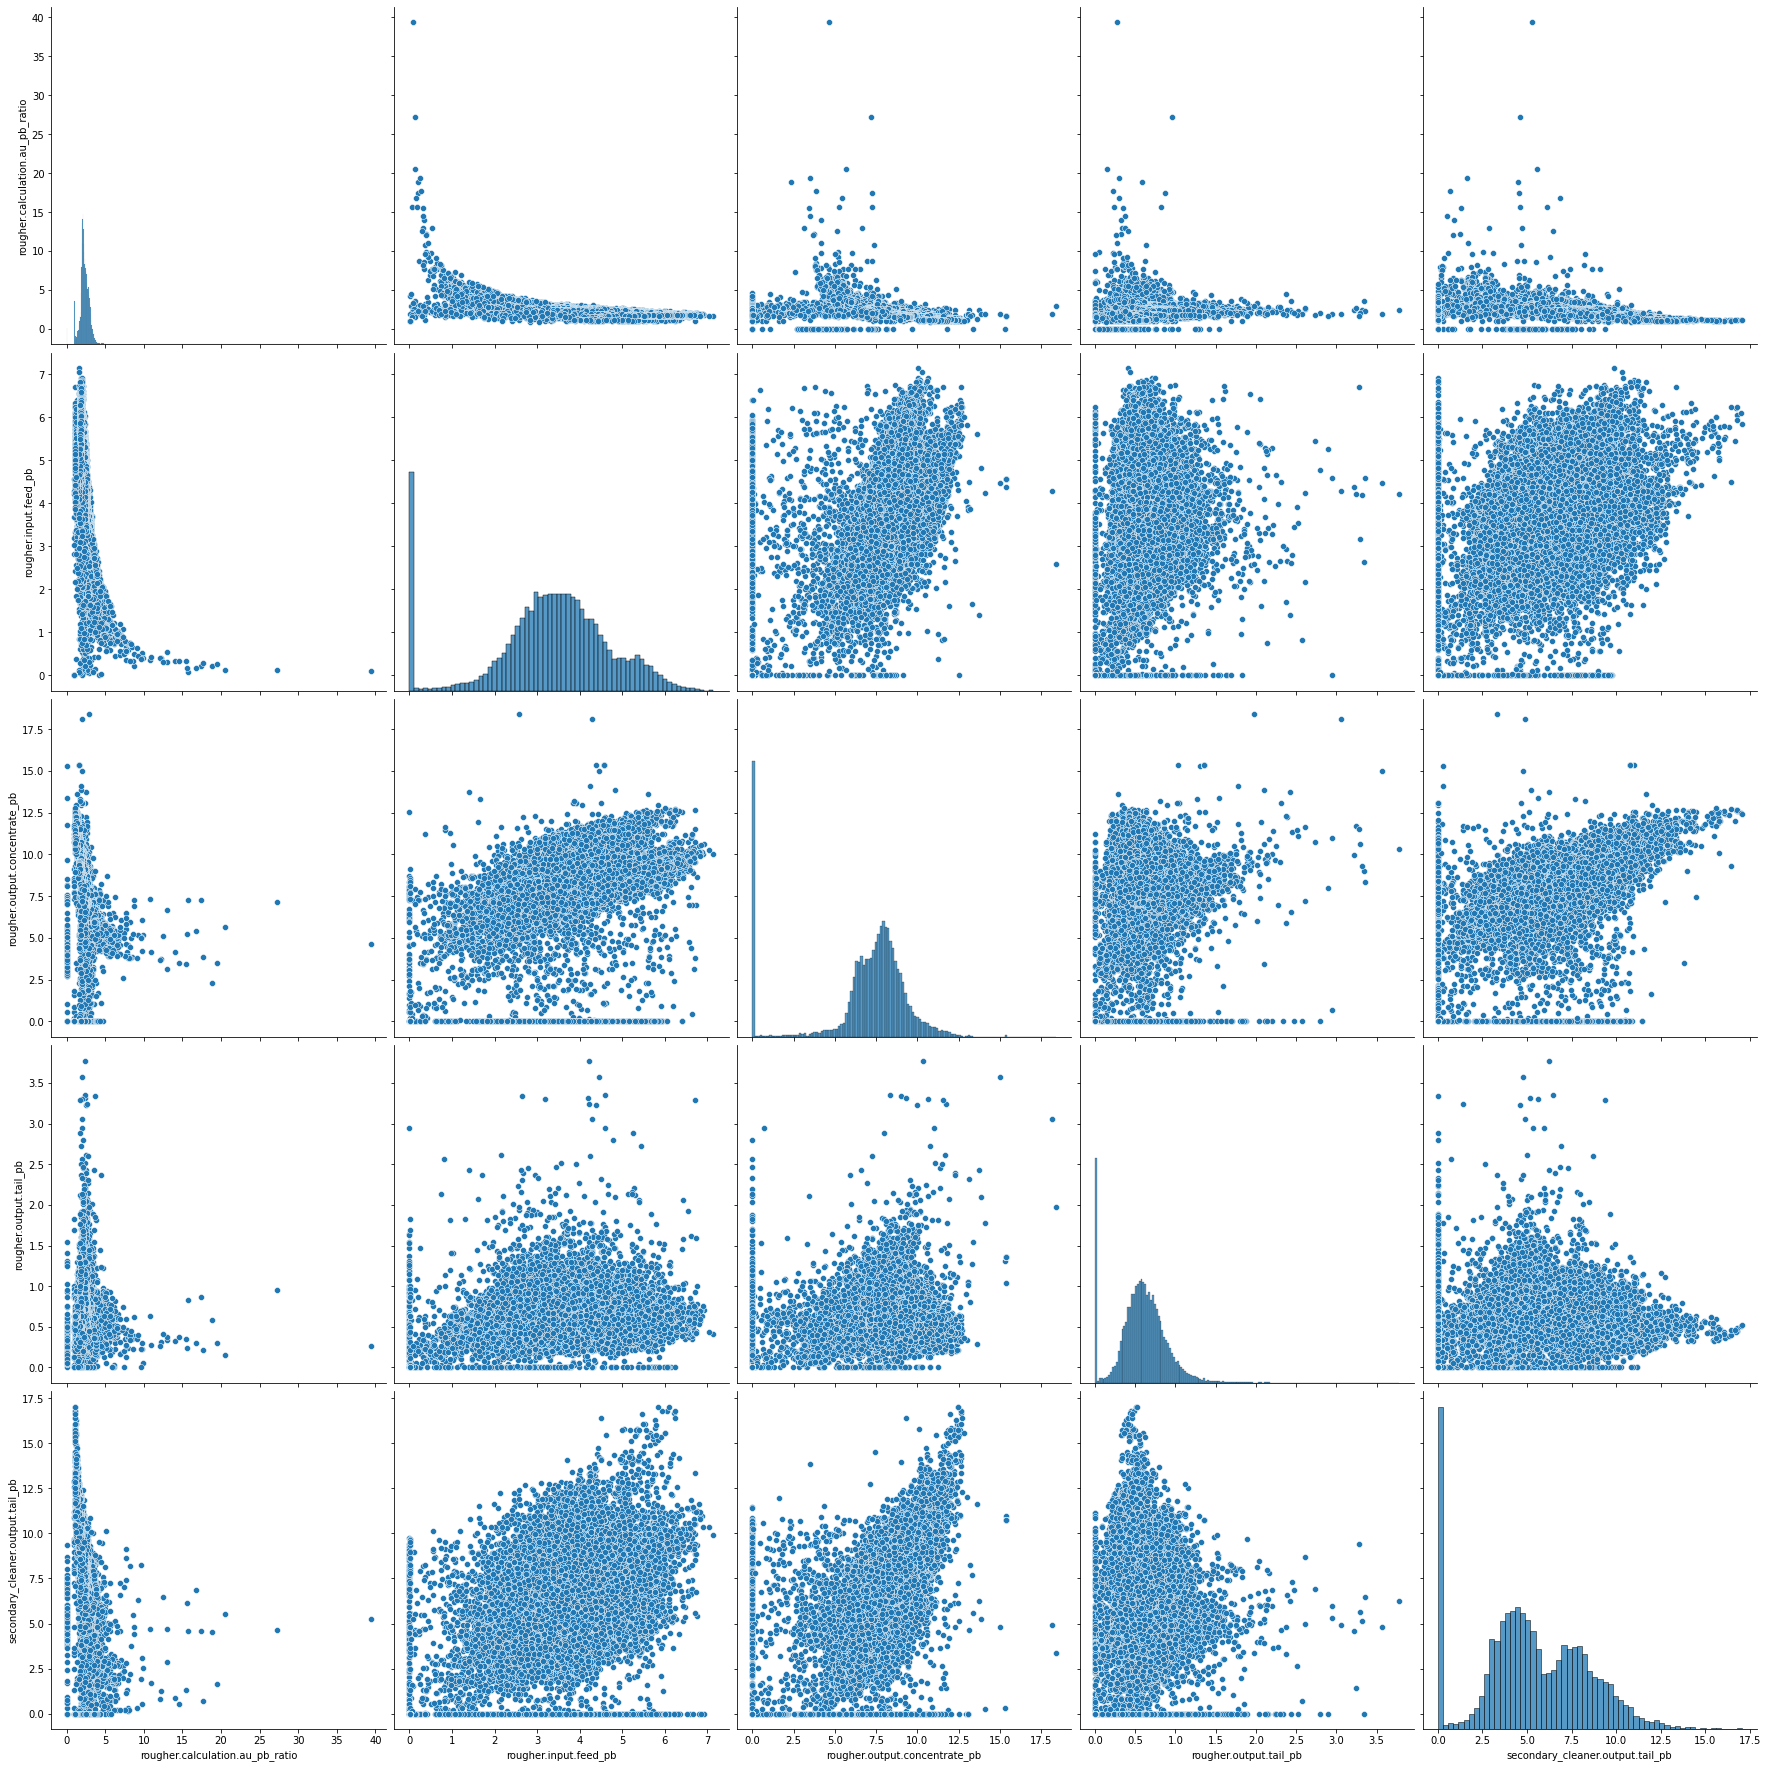

In [76]:
sns.pairplot(full[lead[int(len(lead)/2):]],kind='scatter',height=5)

#### Colloid

In [77]:
colloid_stats = pd.DataFrame(columns=['count','minimum','q1','median','q3','maximum','iqr','big_outliers',
                                    'small_outliers','standard_deviation','variance','mad'],
                           index=colloid)

In [78]:
index = 0
for col in colloid:
    colloid_stats.loc[col] = get_stats(data=full[col])
    index += 1

In [79]:
display(colloid_stats)

count    minimum         q1  \
final.output.concentrate_sol            22331        0.0   7.116799   
final.output.tail_sol                   22445        0.0   8.143576   
primary_cleaner.output.concentrate_sol  21918        0.0    7.00998   
primary_cleaner.output.tail_sol         22365        0.0   5.961535   
rougher.input.feed_sol                  22357        0.0  32.524264   
rougher.output.concentrate_sol          22526        0.0  25.815139   
rougher.output.tail_sol                 19980  10.014648  15.788283   
secondary_cleaner.output.tail_sol       20501        0.0   2.658971   

                                           median         q3    maximum  \
final.output.concentrate_sol             8.908792  10.705824   19.61572   
final.output.tail_sol                   10.212998  11.860824  22.861749   
primary_cleaner.output.concentrate_sol   9.851136  13.180304  22.458114   
primary_cleaner.output.tail_sol          7.873945   9.348743  22.276364   
rougher.input.feed_sol                  36.559955   39.67547  53.477742   
rougher.output.concentrate_sol          29.382638  32.002766  40.089993   
rougher.output.tail_sol                 18.082595  20.084427  66.117188   
secondary_cleaner.output.tail_sol        6.966645  10.152612  33.058594   

                                             iqr big_outliers small_outliers  \
final.output.concentrate_sol            3.589026    16.089363        1.73326   
final.output.tail_sol                   3.717249    17.436697       2.567703   
primary_cleaner.output.concentrate_sol  6.170324     22.43579      -2.245506   
primary_cleaner.output.tail_sol         3.387208    14.429555       0.880723   
rougher.input.feed_sol                  7.151206    50.402279      21.797454   
rougher.output.concentrate_sol          6.187627    41.284206      16.533699   
rougher.output.tail_sol                 4.296144    26.528643       9.344067   
secondary_cleaner.output.tail_sol       7.493641    21.393074       -8.58149   

                                       standard_deviation    variance  \
final.output.concentrate_sol                      3.78495   14.325846   
final.output.tail_sol                            4.079648    16.64353   
primary_cleaner.output.concentrate_sol           4.788323   22.928041   
primary_cleaner.output.tail_sol                  3.087823     9.53465   
rougher.input.feed_sol                          11.493878  132.109227   
rougher.output.concentrate_sol                  10.139895  102.817468   
rougher.output.tail_sol                          3.470427   12.043861   
secondary_cleaner.output.tail_sol                4.277889   18.300332   

                                             mad  
final.output.concentrate_sol             2.74114  
final.output.tail_sol                   2.963528  
primary_cleaner.output.concentrate_sol  3.806434  
primary_cleaner.output.tail_sol         2.359613  
rougher.input.feed_sol                  7.559877  
rougher.output.concentrate_sol          7.063823  
rougher.output.tail_sol                 2.638866  
secondary_cleaner.output.tail_sol       3.729235

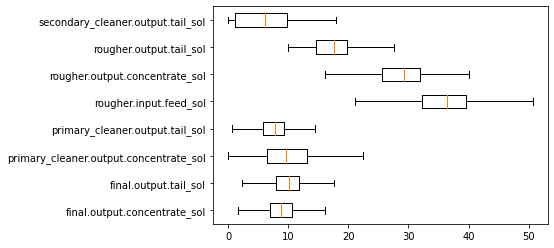

In [80]:
display_stats(full,colloid)

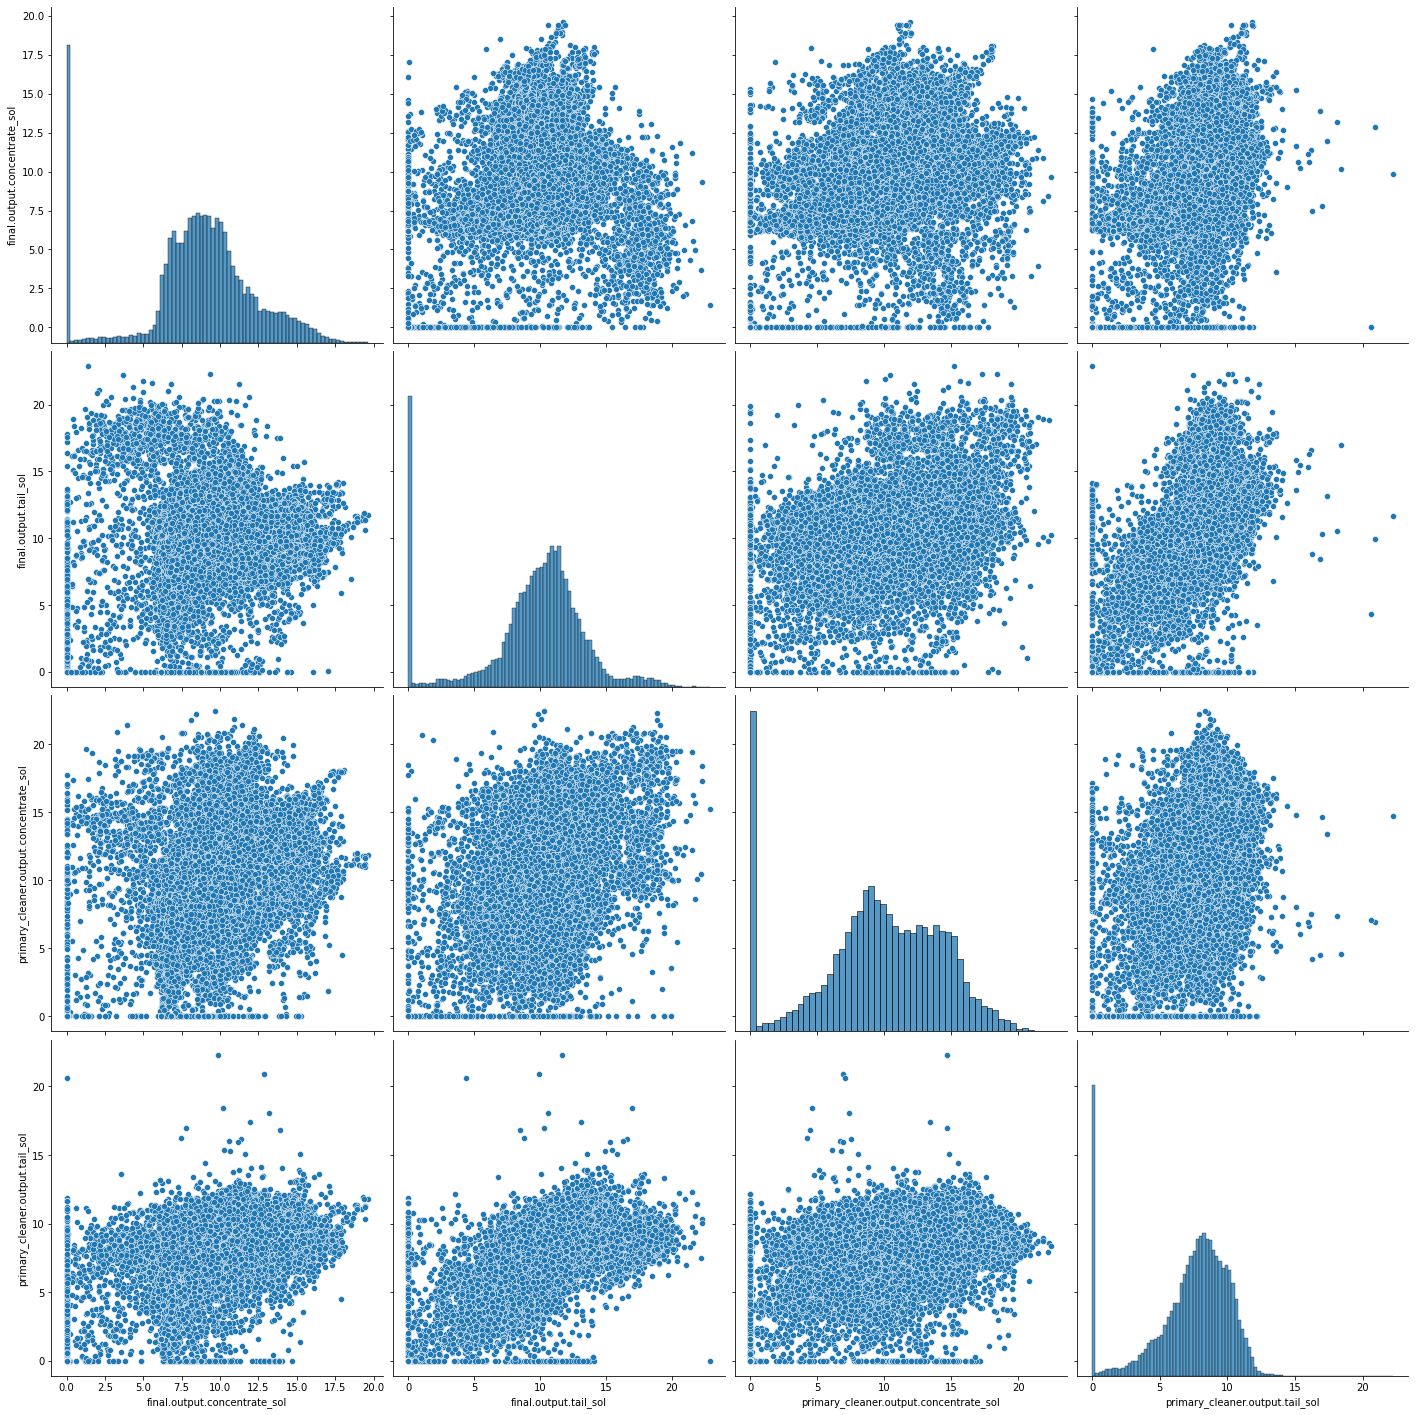

In [81]:
sns.pairplot(full[colloid[:int(len(colloid)/2)]],kind='scatter',height=5)

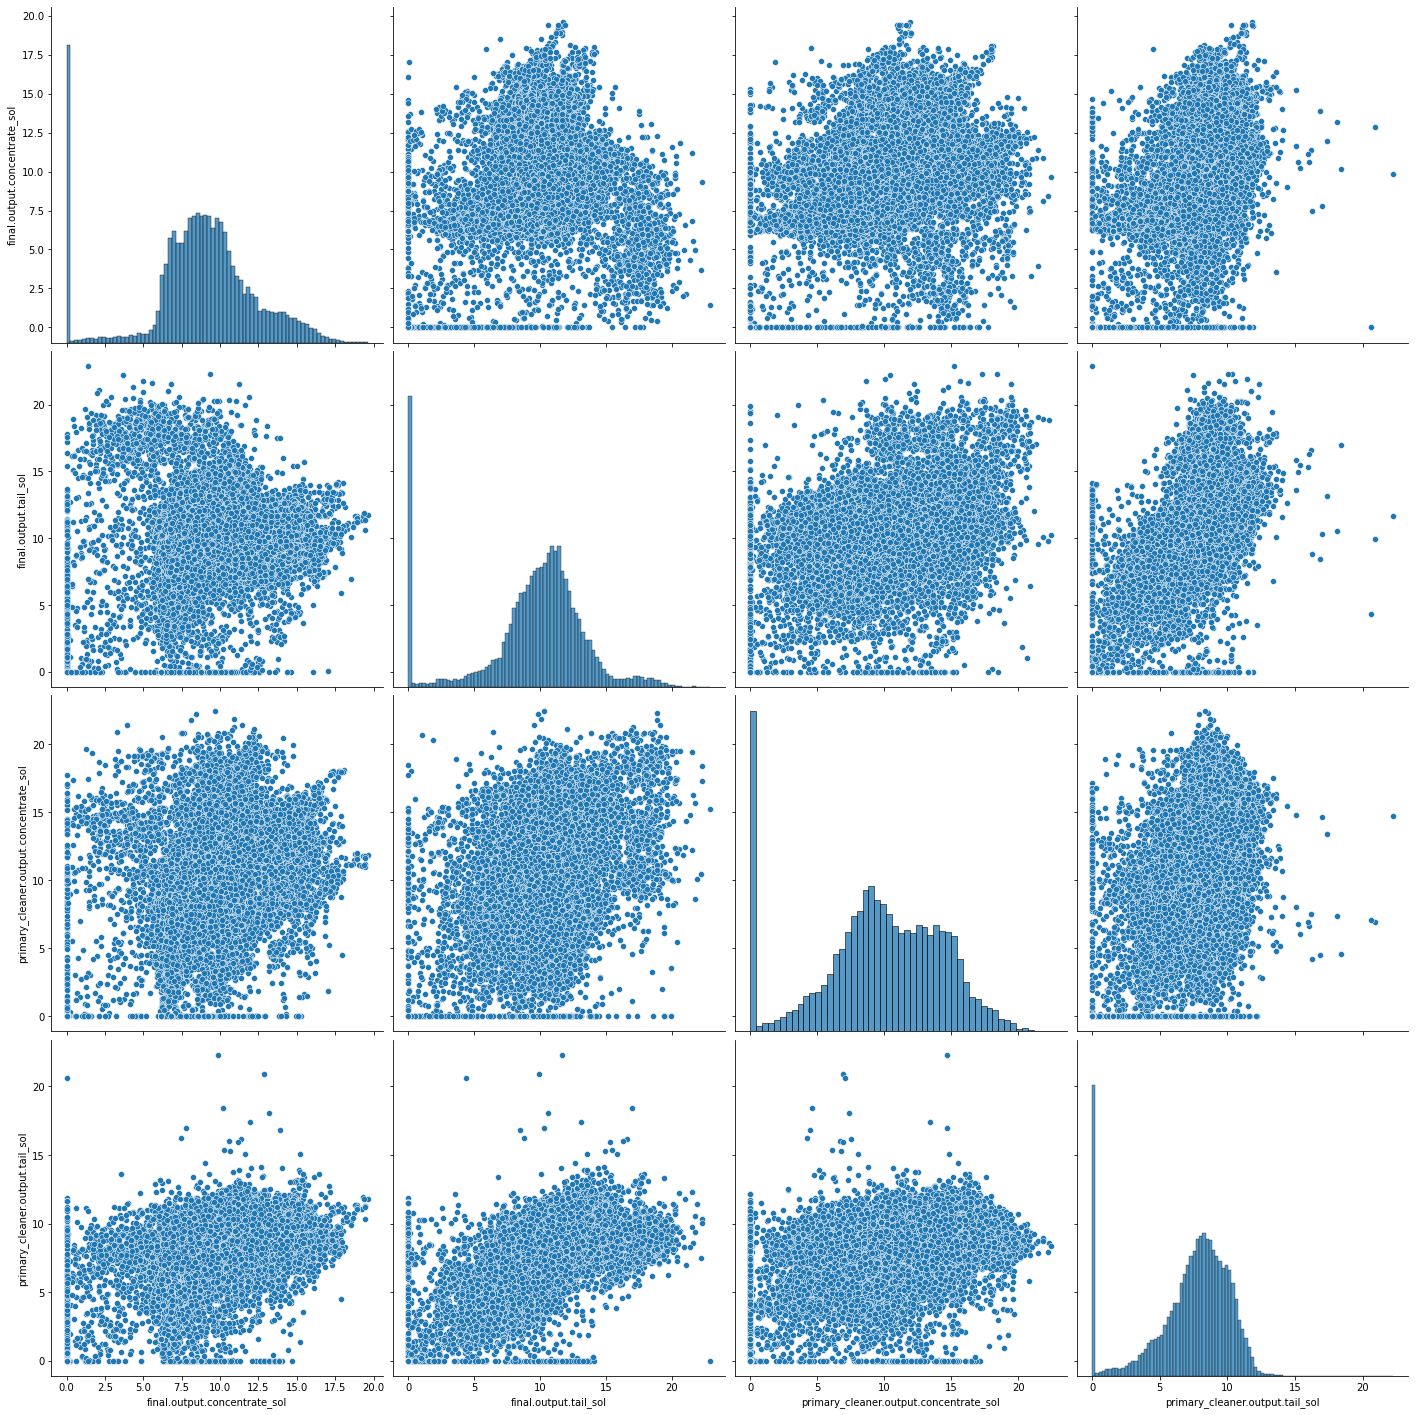

In [82]:
sns.pairplot(full[colloid[:int(len(colloid)/2)]],kind='scatter',height=5)

### Data Preprocessing